Import Necessary libraries

In [1]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch torchvision torchaudio torchmetrics


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install numpy==1.22.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 74.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-serving-api 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.9.3 which is incompatible.
librosa 0.10.0.post2 requires numpy!=1.22.0,!=1.22.1,!=1.22.2,>=1.20.3, but you have numpy 1.22.0 which is incompatible.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.
beatrix-jupyterlab 2023.46.184821 requires jupyter-se

In [5]:
from torchvision import transforms

In [6]:
import torch
import torchvision
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Read the labels dataframe.

In [7]:
labels = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')

In [8]:
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


While looking at labels, we can see that there is a **patientid** column at first which is a unique patient id.

Columns`x,y, left, right` represents the `x` and `y` coordinates and the `left` and `right` position of the classified pneumonia region.

The final column `Target` is used to denote whether patient is suffering from pneumonia or not.

In [9]:
# Dropping Duplicates

labels = labels.drop_duplicates("patientId")

Let's create a `ROOT_PATH` that takes a path to our train dataset.

Additionally, let's define a `SAVE_PATH` that defines path to the place where our processed images are saved.

In [10]:
ROOT_PATH = Path("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/")
SAVE_PATH = Path("Processed")

Let's look at some example images.

Let's create 3x3 subplots to view 9 images along with their labels.

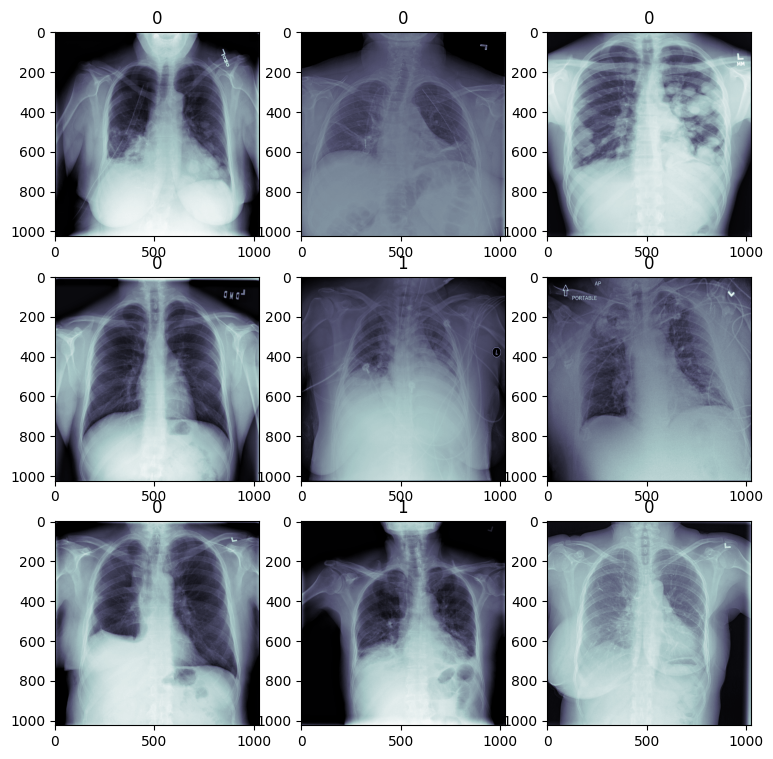

In [11]:
fig, axis = plt.subplots(3, 3, figsize = (9, 9))
c = 0
for i in range(3):
    for j in range(3):
        # Start reading the files.
        patient_id = labels.patientId.iloc[c]
        
        # Create a path to the dicom file of this particular patient/
        dcm_path = ROOT_PATH/patient_id
        
        # Add .dcm extension
        dcm_path = dcm_path.with_suffix(".dcm")
        
        # Reading the dicom file
        dcm = pydicom.read_file(dcm_path).pixel_array
        
        # Extract the labels of the particular patient from labels dataframe
        label = labels['Target'].iloc[c]
        
        # Visualize the image
        axis[i][j].imshow(dcm, cmap = "bone")
        axis[i][j].set_title(label)
        
        c += 1
        
         
        

###  Preprocessing Images

First, we standardize each image pixels by dividing it by 255.

Also, our images are way too large for current neural network architectures to process. So, we need to resize them to shape of 224x224.

To use less space when storing the images, we convert them to `float16`

In [12]:
# Initialization 
sums, sums_squared = 0, 0

# Loop over all patient ids
# To decide if a data is used as training data or validation data
# We can use the enumerate 

for c, patient_id, in enumerate(tqdm(labels.patientId)):
    # Start reading the files.
    patient_id = labels.patientId.iloc[c]
        
    # Create a path to the dicom file of this particular patient/
    dcm_path = ROOT_PATH/patient_id

    # Add .dcm extension
    dcm_path = dcm_path.with_suffix(".dcm")

    # Reading the dicom file and dividing the pixel array by 255
    dcm = pydicom.read_file(dcm_path).pixel_array
    
    # Resizing the image and converting it's type
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    
    # Storing the label in 'label'
    label = labels.Target.iloc[c]
    
    # Identify training/validation
    train_or_val = "train" if c < 24000 else "val"
    
    # Save preprocessed images
    current_save_path = SAVE_PATH/train_or_val/str(label)
    current_save_path.mkdir(parents = True, exist_ok = True)
    np.save(current_save_path/patient_id, dcm_array)
    
    
    # Update sums and sums_squared
    normalizer = 224*224
    

  0%|          | 0/26684 [00:00<?, ?it/s]

In [13]:
mean = 0.49
std = 0.24

### Train and Validation Dataset

To load the generate the data in required format, we can make use of dataset class.

In [14]:
def load_file(path):
    return np.load(path).astype(np.float32)

Next, we can define our train and validation transform:

In [15]:
# Transforms

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomAffine(degrees = (-5, 5), translate = (0, 0.05), scale = (0.9, 1.1)),
    transforms.RandomResizedCrop((224, 224), scale = (0.35, 1))
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [16]:
# DataLoader

train_dataset = torchvision.datasets.DatasetFolder("/kaggle/working/Processed/train/", loader = load_file, extensions = "npy", transform = train_transforms)

val_dataset = torchvision.datasets.DatasetFolder("/kaggle/working/Processed/val/", loader = load_file, extensions = "npy", transform = val_transforms)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


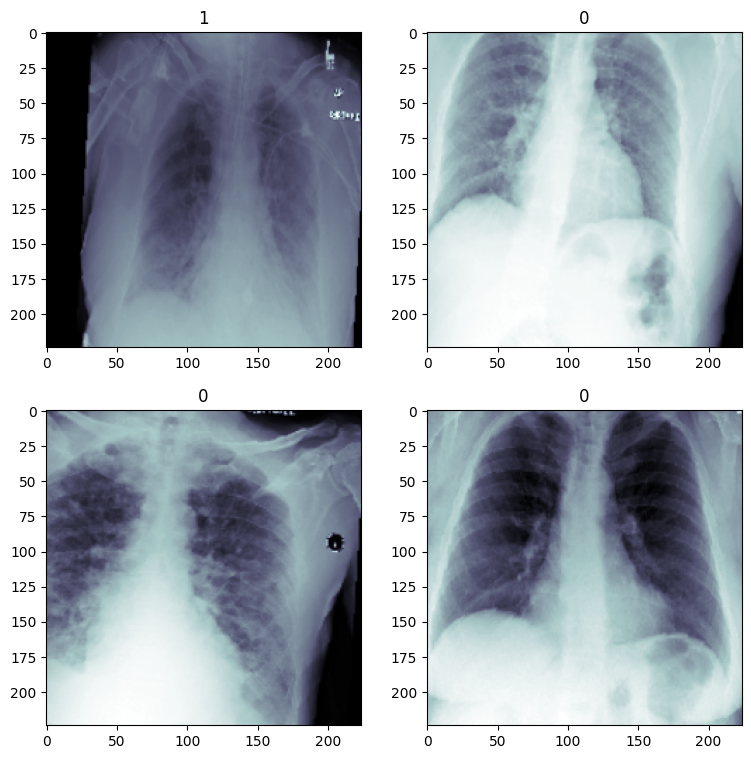

In [17]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))

for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 24000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap = "bone")
        axis[i][j].set_title(label)


In [18]:
batch_size = 64
num_workers = 4

In [19]:
from torch.utils.data import DataLoader

In [20]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = False)

In [21]:
np.unique(train_dataset.targets, return_counts = True)

(array([0, 1]), array([18593,  5407]))

Our dataset is heavily imbalanced. So, we will be doing weighted loss.

In [22]:
# Observing the Resnet18 architecture

torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
class PneumoniaModel(pl.LightningModule):
    
    # Constructor
    def __init__(self):
        super(PneumoniaModel, self).__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features = 512, out_features = 1, bias = True)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor([3]))
        
        self.train_acc = torchmetrics.Accuracy(task = "binary")
        self.val_acc = torchmetrics.Accuracy(task = "binary")
        #self.test_acc = torchmetrics.Accuracy()
        
        
        
    # Activation
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        
        self.log("Train Loss", loss)
        self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label.int()))
        
        return loss
    
    
    
    def on_train_epoch_end(self):
        self.log("Train ACC", self.train_acc.compute())
        
    
    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        
        self.log("Val Loss", loss)
        self.log("Step Val ACC", self.val_acc(torch.sigmoid(pred), label.int()))

        
        
       
    def on_validation_epoch_end(self):
        self.log("Val ACC", self.val_acc.compute())
        
        
    def configure_optimizers(self):
        return[self.optimizer]
    

In [24]:
model = PneumoniaModel()

In [25]:
checkpoint_callback = ModelCheckpoint(
    monitor = "Val ACC",
    save_top_k = 1,
    mode = "max",
    dirpath = "./saved_models"
)

In [26]:
# Configure the trainer
trainer = pl.Trainer(logger = TensorBoardLogger(save_dir = "./logs"), log_every_n_steps = 64, callbacks = checkpoint_callback, max_epochs = 1)

In [27]:
# Train the model
trainer.fit(model, train_loader, val_loader)

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Validation: 0it [00:00, ?it/s]

In [28]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [31]:
model = PneumoniaModel.load_from_checkpoint("/kaggle/working/saved_models/epoch=0-step=375.ckpt")

In [32]:
model.eval()

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [33]:
model.to(device)

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [ ]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        
        # Calculate probabilities
        pred = torch.sigmoid(model(data)[0].cpu())
        
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [ ]:
# Accuracy
acc = torchmetrics.Accuracy(task = "binary")(preds, labels)

# Precision
precision = torchmetrics.Precision(task = "binary")(preds, labels)

# Recall
recall = torchmetrics.Recall(task = "binary")(preds, labels)

# Confusion Matrix
cm = torchmetrics.ConfusionMatrix(num_classes=2, task = "binary")(preds, labels)

In [ ]:
print(f"Accuracy : {acc}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")

### Class Activation Map
Learning deep features for discriminative localization.

In [ ]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [ ]:
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248)
])

In [ ]:
val_dataset = torchvision.datasets.DatasteFolder("Processes/val", loader = load_file, extensions = 'npy', transform = val_transform)

In [ ]:
temp_model = torchvision.models.resnet18()

In [ ]:
list(temp_model.children())

In [ ]:
list(temp_model.children())[:-2]

In [ ]:
torch.nn.sequential(*list(temp_model.children())[:-2])

class PneumoniaModel(pl.LightningMod
    
    
        

In [ ]:
class PneumoniaModel(pl.LightningModule):
    
    def __init__(self):
        super(PneumoniaModel, self).__init__()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride = (2, 2), padding = (3, 3), bias = False)
        self.model.fc = torch.nn.Linear(in_)features=512, out_features=1)
        
        self.feature_map = torch.nn.Sequential(*list(temp_model.children())[:-2])
        
        
    def forward(self, data):
        feature_map = self.feature_map(data)
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size = (1, 1))
        ave_output_flattened = torch.flatten(avg_pool_output)
        pred = self.model.fc(avg_pool_flattened)
        return pred, feature_map

In [ ]:
model = PneumoniaModel.load_from_checkpoint("weights/weig.....0", strict = False)
model.eval():

In [ ]:
def cam(model, img):
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    features = features.reshape((512, 49))
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()
    
    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(7, 7).cpu()
    return cam_img, torch.sigmoid(pred)

In [ ]:
def visualize(img, cam, pred):
    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]
    
    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(img, cmap = 'bone')
    axis[1].imshow(img, cmap= 'bone')
    axis[1].imshow(cam, alpha=0.5, cmap="jet")
    plt.title(pred>0.5)

In [ ]:
img = val_dataset[-6][0]
activation_map, pred = cam(model, img)

In [ ]:
visualize(img, activation_map, pred)